In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde
from sklearn.svm import SVC

## Create moons dataset

In [2]:
def make_moons_da2(n_samples1=(150,150), n_samples2=None, rotation=50, noise=0.05):
    if n_samples2 is None:
        n_samples2 = n_samples1
    Xs, ys = make_moons(n_samples=n_samples1,
                        noise=noise, random_state=42)
    Xs[:, 0] -= 0.5
    Xs[:, 1] -= 0.25
    
    Xt, yt = make_moons(n_samples=n_samples2,
                        noise=noise, random_state=42)
    Xt[:, 0] -= 0.5
    Xt[:, 1] -= 0.25
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )
    Xt = Xt.dot(rot_matrix)
    yt = yt
    return Xs, ys, Xt, yt

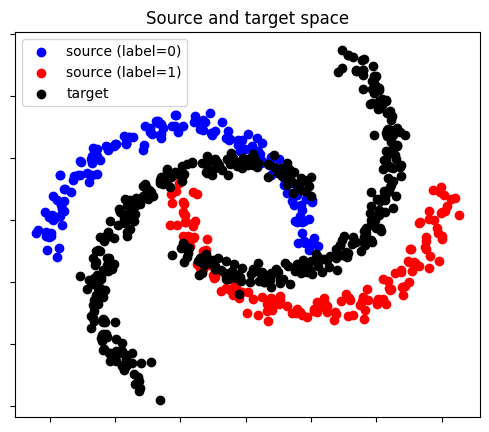

In [3]:
Xs, ys, Xt, yt = make_moons_da2(rotation=50, n_samples1=(150, 150), n_samples2=(200, 200))
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Source and target space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source (label=0)", c="blue")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source (label=1)", c="red")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target",  c="black")
ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='out')

## Setting for (P)OT

### Create dataset

In [4]:
Xs, ys, Xt, yt = make_moons_da2(rotation=60)

r = np.ones(Xs.shape[0]) / Xs.shape[0]
c = np.ones(Xt.shape[0]) / Xt.shape[0]
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()
min_mass = min(r.sum(), c.sum())

### Apply KMeans

In [5]:
from sklearn.cluster import KMeans

In [6]:
Xs, ys, Xt, yt = make_moons_da2(rotation=60,
                                n_samples1=(150, 150), 
                                n_samples2=(200, 200),
                                )

ns, nt = Xs.shape[0], Xt.shape[0]
n_clusters = min(ns, nt)
r = np.ones(Xs.shape[0])
c = np.ones(Xt.shape[0])
if ns < nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xt)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xt to new centroids
    Xt = centers
    c = np.bincount(labels, minlength=n_clusters).astype(np.float64)
elif ns > nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xs)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xs to new centroids
    Xs = centers
    r = np.bincount(labels, minlength=n_clusters).astype(np.float64)
    
C = pairwise_distances(Xs, centers, metric="sqeuclidean")
C /= C.max()

max_mass = max(r.sum(), c.sum())
r /= max_mass
c /= max_mass

min_mass = min(r.sum(), c.sum())

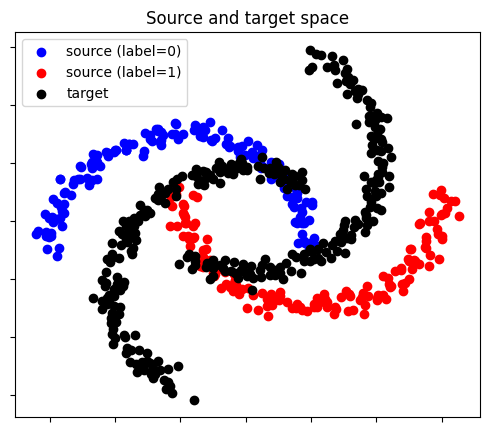

In [7]:
# Xs, ys, Xt, yt = make_moons_da2(rotation=50, n_samples1=(150, 150), n_samples2=(200, 200))
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Source and target space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source (label=0)", c="blue")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source (label=1)", c="red")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target",  c="black")
ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='out')

In [8]:
# Test set
rotation = 60
X_test, y_test = make_moons(n_samples=(10000,10000), noise=0.05)
X_test[:, 0] -= 0.5
X_test[:, 1] -= 0.25
theta = np.radians(-rotation)
cos_theta, sin_theta = np.cos(theta), np.sin(theta)
rot_matrix = np.array(
    ((cos_theta, -sin_theta),
     (sin_theta, cos_theta))
)
X_test = X_test.dot(rot_matrix)

## Plot decision boundary

In [9]:
def plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svc, ax):
    # create a mesh to plot decision boundary
    h = .02
    x_min, x_max = hat_Xs[:, 0].min() - 1, hat_Xs[:, 0].max() + 1
    y_min, y_max = hat_Xs[:, 1].min() - 1, hat_Xs[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = svclassifier.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = Z[:,1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    ax.contour(xx, yy, Z, cmap='RdBu', alpha=0.8)
    #plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8,vmin=Z.min(), vmax=Z.max())

    x1,y1 = hat_Xs[ys==0, 0], hat_Xs[ys==0, 1]
    xy1 = np.vstack([x1,y1])
    z1 = gaussian_kde(xy1)(np.c_[xx.ravel(), yy.ravel()].T)

    x2,y2 = hat_Xs[ys==1, 0], hat_Xs[ys==1, 1]
    xy2 = np.vstack([x2,y2])
    z2 = gaussian_kde(xy2)(np.c_[xx.ravel(), yy.ravel()].T)

    ax.scatter(xx.ravel(), yy.ravel(), c = z1/(max(z1) - min(z1)) - z2 /(max(z2)- min(z2)), s=5 ,cmap = 'RdBu')

    ax.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", c="tab:blue",s = 2)
    ax.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", c="tab:red",s = 2)

    ax.scatter(Xt[:, 0], Xt[:, 1], label="target",  c="black",s = 2)

## OT

In [10]:
Xs, ys, Xt, yt = make_moons_da2(rotation=60,
                                n_samples1=(150, 150), 
                                n_samples2=(200, 200),
                                )
r = np.ones(Xs.shape[0])
c = np.ones(Xt.shape[0])
r /= r.sum()
c /= c.sum()

C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()

In [11]:
from ot_solvers import apdagd, sinkhorn
import ot
T_apdagd= ot.sinkhorn(r / r.sum(), c / c.sum(),
                      C, stopThr=6.25e-4, reg=4.38e-04
                     )

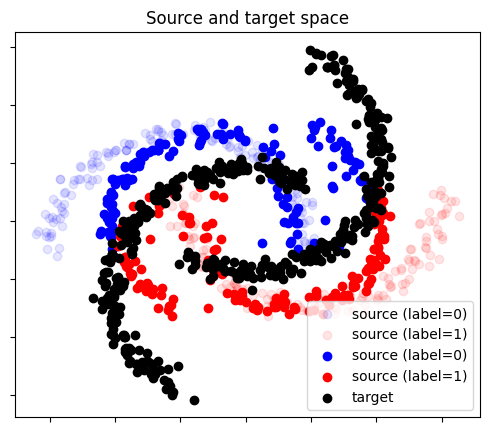

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

hat_Xs = Xs.shape[0] * (T_apdagd @ Xt)

# hat_Xs = np.dot(T_apdagd / (1e-7 + T_apdagd.sum(axis=1)[:, np.newaxis]), Xt)

# svclassifier = SVC(kernel='rbf')
# svclassifier.fit(hat_Xs, ys)
ax1.set_title("Source and target space")

ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source (label=0)", c="blue", alpha=0.1)
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source (label=1)", c="red", alpha=0.1)

ax1.scatter(hat_Xs[ys==0, 0], Xs[ys==0, 1], label="source (label=0)", c="blue")
ax1.scatter(hat_Xs[ys==1, 0], Xs[ys==1, 1], label="source (label=1)", c="red")


ax1.scatter(Xt[:, 0], Xt[:, 1], label="target",  c="black")

ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='out')

### Train SVC

In [13]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)

SVC()

### Test error

In [14]:
np.mean(svclassifier.predict(X_test) != y_test)

0.22415

### Decision boundary

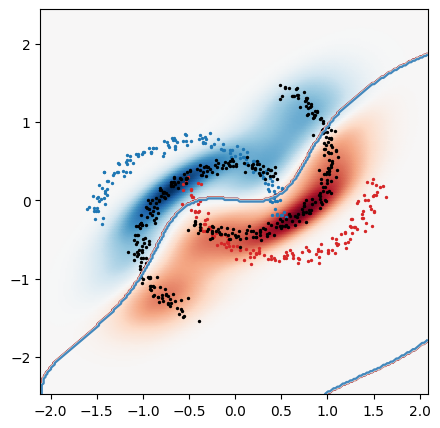

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax)

## POT

In [16]:
Xs, ys, Xt, yt = make_moons_da2(rotation=60,
                                n_samples1=(150, 150), 
                                n_samples2=(200, 200),
                                )
Xs_orig, Xt_orig = Xs.copy(), Xt.copy()

ns, nt = Xs.shape[0], Xt.shape[0]
n_clusters = min(ns, nt)
r = np.ones(Xs.shape[0])
c = np.ones(Xt.shape[0])
if ns < nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xt)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xt to new centroids
    Xt = centers
    c = np.bincount(labels, minlength=n_clusters).astype(np.float64)
elif ns > nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xs)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xs to new centroids
    Xs = centers
    r = np.bincount(labels, minlength=n_clusters).astype(np.float64)
    
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()

max_mass = max(r.sum(), c.sum())
r /= max_mass
c /= max_mass

min_mass = min(r.sum(), c.sum())

In [17]:
from pot_solvers import apdagd
alpha = 0.999
T_apdagd, logs_apdagd = apdagd(r, c,
                               C, s=alpha * min_mass, tol=1e-2, verbose=True, print_every=500,
                               check_termination=True, num_iters=5000,
                               # gamma=1e-3
                               )

Regularization parameter: gamma = 4.38e-04
Tolerance for duality gap        : 6.25e-04
Tolerance for ||X1 + p - a||_2   : 6.25e-04
Tolerance for ||X.T 1 + q - b||_2: 6.25e-04
Tolerance for ||1.T X 1 - s||_2  : 6.25e-04
Iter =   500 | Duality gap = 7.15e-03 | ||Ax - b|| = 1.50e-02 | L estimate =  512.0
Iter =  1000 | Duality gap = 5.50e-03 | ||Ax - b|| = 6.58e-03 | L estimate =  512.0
Iter =  1500 | Duality gap = 2.29e-03 | ||Ax - b|| = 2.77e-03 | L estimate = 1024.0
Iter =  2000 | Duality gap = 9.27e-04 | ||Ax - b|| = 1.27e-03 | L estimate = 1024.0
Iter =  2500 | Duality gap = 7.62e-04 | ||Ax - b|| = 9.27e-04 | L estimate = 1024.0
Iter =  3000 | Duality gap = 6.25e-04 | ||Ax - b|| = 7.03e-04 | L estimate = 2048.0
APDAGD converged after 3129 iterations


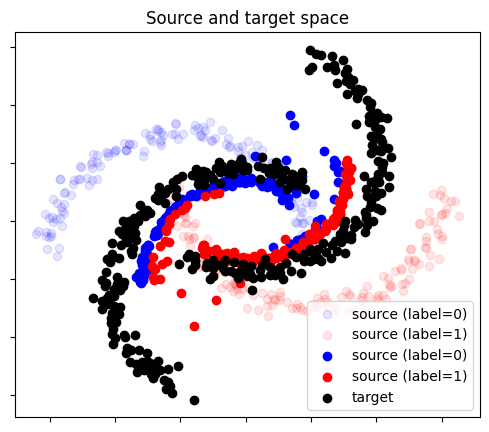

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

hat_Xs = Xs.shape[0] * (T_apdagd @ Xt)

# hat_Xs = np.dot(T_apdagd / (1e-7 + T_apdagd.sum(axis=1)[:, np.newaxis]), Xt)

# svclassifier = SVC(kernel='rbf')
# svclassifier.fit(hat_Xs, ys)
ax1.set_title("Source and target space")

ax1.scatter(Xs_orig[ys==0, 0], Xs_orig[ys==0, 1], label="source (label=0)", c="blue", alpha=0.1)
ax1.scatter(Xs_orig[ys==1, 0], Xs_orig[ys==1, 1], label="source (label=1)", c="red", alpha=0.1)

ax1.scatter(hat_Xs[ys==0, 0], hat_Xs[ys==0, 1], label="source (label=0)", c="blue")
ax1.scatter(hat_Xs[ys==1, 0], hat_Xs[ys==1, 1], label="source (label=1)", c="red")


ax1.scatter(Xt[:, 0], Xt[:, 1], label="target",  c="black")

ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='out')

### Fit SVC

In [19]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)

SVC()

### Test error

In [20]:
np.mean(svclassifier.predict(X_test) != y_test)

0.11025

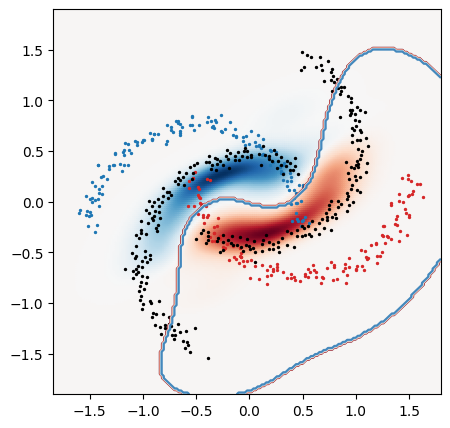

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax)

## Plot

## OT vs. POT

Regularization parameter: gamma = 4.38e-04
Tolerance for duality gap        : 6.25e-04
Tolerance for ||X1 + p - a||_2   : 6.25e-04
Tolerance for ||X.T 1 + q - b||_2: 6.25e-04
Tolerance for ||1.T X 1 - s||_2  : 6.25e-04
Iter =   500 | Duality gap = 7.15e-03 | ||Ax - b|| = 1.50e-02 | L estimate =  512.0
Iter =  1000 | Duality gap = 5.50e-03 | ||Ax - b|| = 6.58e-03 | L estimate =  512.0
Iter =  1500 | Duality gap = 2.29e-03 | ||Ax - b|| = 2.77e-03 | L estimate = 1024.0
Iter =  2000 | Duality gap = 9.27e-04 | ||Ax - b|| = 1.27e-03 | L estimate = 1024.0
Iter =  2500 | Duality gap = 7.62e-04 | ||Ax - b|| = 9.27e-04 | L estimate = 1024.0
Iter =  3000 | Duality gap = 6.25e-04 | ||Ax - b|| = 7.03e-04 | L estimate = 2048.0
APDAGD converged after 3129 iterations


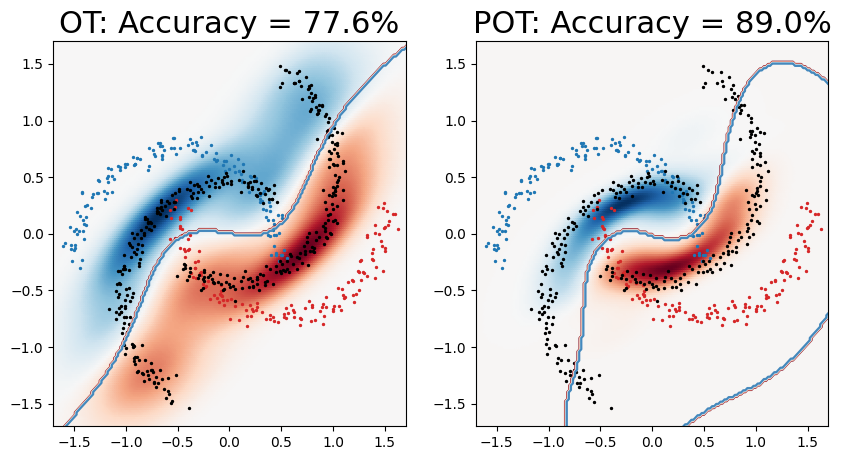

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# OT
ax = axes[0]
Xs, ys, Xt, yt = make_moons_da2(rotation=60, n_samples1=(150, 150), n_samples2=(200, 200))
r = np.ones(Xs.shape[0]); c = np.ones(Xt.shape[0]); r /= r.sum(); c /= c.sum()
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()
T_apdagd = ot.sinkhorn(r / r.sum(), c / c.sum(), C, stopThr=6.25e-4, reg=4.38e-04)
hat_Xs = Xs.shape[0] * (T_apdagd @ Xt)
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)
error = np.mean(svclassifier.predict(X_test) != y_test)
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax=axes[0])
ax.set_title(f"OT: Accuracy = {100 * (1-error):.1f}%", size=22)

# POT
from pot_solvers import apdagd
ax = axes[1]
Xs, ys, Xt, yt = make_moons_da2(rotation=60,
                                n_samples1=(150, 150), 
                                n_samples2=(200, 200),
                                )
Xs_orig, Xt_orig = Xs.copy(), Xt.copy()

ns, nt = Xs.shape[0], Xt.shape[0]
n_clusters = min(ns, nt)
r = np.ones(Xs.shape[0])
c = np.ones(Xt.shape[0])
if ns < nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xt)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xt to new centroids
    Xt = centers
    c = np.bincount(labels, minlength=n_clusters).astype(np.float64)
elif ns > nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xs)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xs to new centroids
    Xs = centers
    r = np.bincount(labels, minlength=n_clusters).astype(np.float64)
    
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()

max_mass = max(r.sum(), c.sum())
r /= max_mass
c /= max_mass

min_mass = min(r.sum(), c.sum())

alpha = 0.999
T_apdagd, logs_apdagd = apdagd(r, c,
                               C, s=alpha * min_mass, tol=1e-2, verbose=True, print_every=500,
                               check_termination=True, num_iters=5000,
                               save_iterates=False,
                               )
hat_Xs = Xs.shape[0] * (T_apdagd @ Xt)
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)
error = np.mean(svclassifier.predict(X_test) != y_test)
ax.set_title(f"POT: Accuracy = {100 * (1-error):.1f}%", size=22)
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax)

for ax in axes:
    ax.set_ylim([-1.7, 1.7])
    ax.set_xlim([-1.7, 1.7])

plt.savefig("figures/domain_adaptation_moons.pdf", bbox_inches="tight")

## POT: Sinkhorn vs. APDAGD

Regularization parameter: gamma = 4.38e-04
Sinkhorn tolerance      : tol   = 5.68e-04
Iter =   500 | Loss = 1.25e-01
Iter =  1000 | Loss = 3.36e-02
Iter =  1500 | Loss = 1.00e-02
Iter =  2000 | Loss = 1.62e-03
Sinkhorn converged after 2284 iterations
Regularization parameter: gamma = 4.38e-04
Tolerance for duality gap        : 6.25e-04
Tolerance for ||X1 + p - a||_2   : 6.25e-04
Tolerance for ||X.T 1 + q - b||_2: 6.25e-04
Tolerance for ||1.T X 1 - s||_2  : 6.25e-04
Iter =   500 | Duality gap = 7.15e-03 | ||Ax - b|| = 1.50e-02 | L estimate =  512.0
Iter =  1000 | Duality gap = 5.50e-03 | ||Ax - b|| = 6.58e-03 | L estimate =  512.0
Iter =  1500 | Duality gap = 2.29e-03 | ||Ax - b|| = 2.77e-03 | L estimate = 1024.0
Iter =  2000 | Duality gap = 9.27e-04 | ||Ax - b|| = 1.27e-03 | L estimate = 1024.0
Iter =  2500 | Duality gap = 7.62e-04 | ||Ax - b|| = 9.27e-04 | L estimate = 1024.0
Iter =  3000 | Duality gap = 6.25e-04 | ||Ax - b|| = 7.03e-04 | L estimate = 2048.0
APDAGD converged after 312

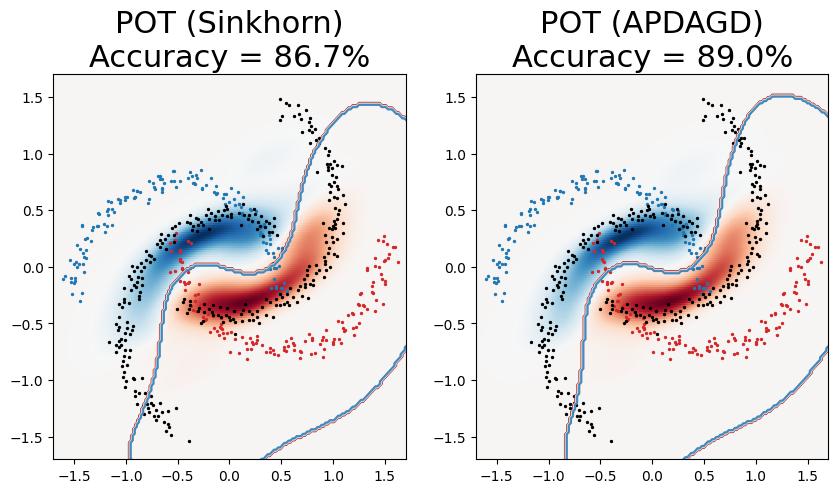

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

from pot_solvers import apdagd, sinkhorn
ax = axes[0]
Xs, ys, Xt, yt = make_moons_da2(rotation=60,
                                n_samples1=(150, 150), 
                                n_samples2=(200, 200),
                                )
Xs_orig, Xt_orig = Xs.copy(), Xt.copy()

ns, nt = Xs.shape[0], Xt.shape[0]
n_clusters = min(ns, nt)
r = np.ones(Xs.shape[0])
c = np.ones(Xt.shape[0])
if ns < nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xt)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xt to new centroids
    Xt = centers
    c = np.bincount(labels, minlength=n_clusters).astype(np.float64)
elif ns > nt:
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xs)
    centers = km.cluster_centers_
    labels = km.labels_
    # Change Xs to new centroids
    Xs = centers
    r = np.bincount(labels, minlength=n_clusters).astype(np.float64)
    
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
C /= C.max()

max_mass = max(r.sum(), c.sum())
r /= max_mass
c /= max_mass

min_mass = min(r.sum(), c.sum())

# Sinkhorn
ax = axes[0]
alpha = 0.999
T_sinkhorn, logs_sinkhron = sinkhorn(r, c,
                               C, s=alpha * min_mass, tol=1e-2, verbose=True, print_every=500,
                               check_termination=True, num_iters=5000,
                               save_iterates=False,
                               )
hat_Xs = Xs.shape[0] * (T_sinkhorn @ Xt)
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)
error = np.mean(svclassifier.predict(X_test) != y_test)
ax.set_title(f"POT (Sinkhorn)\nAccuracy = {100 * (1-error):.1f}%", size=22)
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax)


# APDAGD
ax = axes[1]
T_apdagd, logs_apdagd = apdagd(r, c,
                               C, s=alpha * min_mass, tol=1e-2, verbose=True, print_every=500,
                               check_termination=True, num_iters=5000,
                               save_iterates=False,
                               )
hat_Xs = Xs.shape[0] * (T_apdagd @ Xt)
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)
error = np.mean(svclassifier.predict(X_test) != y_test)
ax.set_title(f"POT (APDAGD)\nAccuracy = {100 * (1-error):.1f}%", size=22)
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax)

for ax in axes:
    ax.set_ylim([-1.7, 1.7])
    ax.set_xlim([-1.7, 1.7])

plt.savefig("figures/domain_adaptation_pot_apdagd_sinkhorn.pdf", bbox_inches="tight")